In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, matplotlib as mpl, seaborn as sns, warnings

%matplotlib inline
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
plt.rc('font', family='NanumGothic')
rc('font', family=font_name)
mpl.rcParams['axes.unicode_minus'] = False

plt.style.use('ggplot')
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]

warnings.filterwarnings(action='ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR, SVR
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [2]:
df_raw = pd.read_csv('../data/jeju_data_ver1/201901-202003.csv')

In [3]:
df_raw.head()

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3


# 서울, 경기, 제주 제외 지역 데이터만 추출

In [14]:
df = df_raw[~df_raw['CARD_SIDO_NM'].isin(['경기', '서울', '제주'])]

In [15]:
df.fillna('세종시', inplace=True)

In [16]:
df.columns

Index(['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM',
       'HOM_CCG_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'CSTMR_CNT', 'AMT', 'CNT'],
      dtype='object')

In [17]:
df.drop(['CARD_CCG_NM','HOM_SIDO_NM','HOM_CCG_NM'], axis=1, inplace=True)

In [18]:
df = df.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AGE', 'SEX_CTGO_CD', 'FLC']).sum().reset_index()

In [19]:
df['CV'] = 0
df.loc[df['REG_YYMM']==202001, 'CV'] = 1
df.loc[df['REG_YYMM']==202002, 'CV'] = 2
df.loc[df['REG_YYMM']==202003, 'CV'] = 3

In [20]:
other = df.groupby(['REG_YYMM', 'STD_CLSS_NM', 'AGE', 'SEX_CTGO_CD', 'FLC'])['AMT', 'CNT'].sum().reset_index()

In [21]:
other['DATE'] = pd.to_datetime(other['REG_YYMM'], format='%Y%m')

Text(0.5, 1.0, '월별 업종별 카드 사용금액 추이')

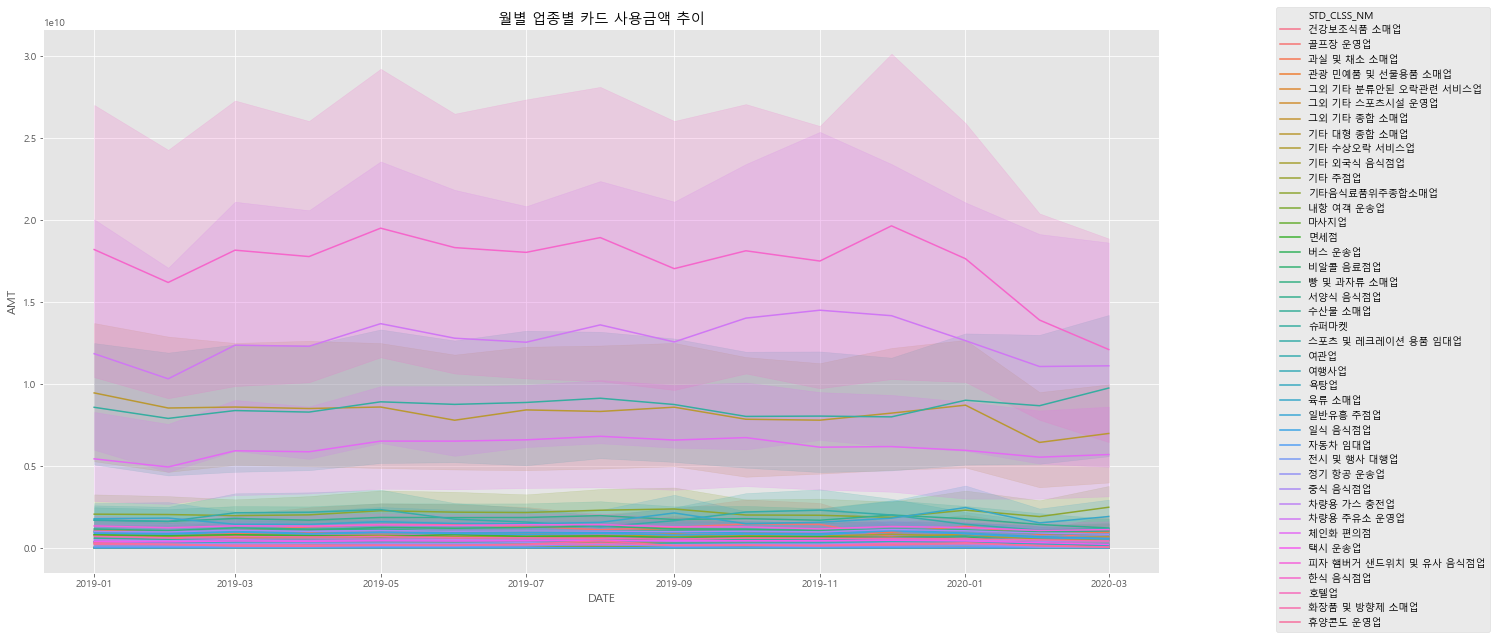

In [22]:
plt.figure(figsize=(20,10))
sns.lineplot(data=other, x='DATE', y='AMT', hue='STD_CLSS_NM')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('월별 업종별 카드 사용금액 추이')

# 전월 대비 증감률 생성

In [23]:
other_1 = other.groupby(['REG_YYMM', 'STD_CLSS_NM'])['AMT', 'CNT'].sum().reset_index()

In [24]:
tmp = other_1.pivot_table(index='REG_YYMM', columns='STD_CLSS_NM', values='AMT', aggfunc='sum').apply(lambda x: x.diff() / x * 100).fillna(0)
stack_AMT_diff = tmp.stack().reset_index().rename(columns={0:'AMT_diff'})
stack_AMT_diff

,REG_YYMM,STD_CLSS_NM,AMT_diff
0,201901,건강보조식품 소매업,0.000000
1,201901,골프장 운영업,0.000000
2,201901,과실 및 채소 소매업,0.000000
3,201901,관광 민예품 및 선물용품 소매업,0.000000
4,201901,그외 기타 분류안된 오락관련 서비스업,0.000000
...,...,...,...
610,202003,피자 햄버거 샌드위치 및 유사 음식점업,4.645414
611,202003,한식 음식점업,-14.864833
612,202003,호텔업,-219.042821
613,202003,화장품 및 방향제 소매업,-16.361970


In [25]:
tmp = other_1.pivot_table(index='REG_YYMM', columns='STD_CLSS_NM', values='CNT', aggfunc='sum').apply(lambda x: x.diff() / x * 100).fillna(0)
stack_CNT_diff = tmp.stack().reset_index().rename(columns={0:'CNT_diff'})
stack_CNT_diff

,REG_YYMM,STD_CLSS_NM,CNT_diff
0,201901,건강보조식품 소매업,0.000000
1,201901,골프장 운영업,0.000000
2,201901,과실 및 채소 소매업,0.000000
3,201901,관광 민예품 및 선물용품 소매업,0.000000
4,201901,그외 기타 분류안된 오락관련 서비스업,0.000000
...,...,...,...
610,202003,피자 햄버거 샌드위치 및 유사 음식점업,1.724292
611,202003,한식 음식점업,-11.774169
612,202003,호텔업,-81.705531
613,202003,화장품 및 방향제 소매업,-18.692433


In [26]:
CLSS_df = pd.merge(stack_AMT_diff, stack_CNT_diff, on=['REG_YYMM', 'STD_CLSS_NM'])
CLSS_df = CLSS_df[CLSS_df['REG_YYMM'].isin([202003])].groupby(['STD_CLSS_NM'])['AMT_diff','CNT_diff'].sum()
CLSS_df

,AMT_diff,CNT_diff
STD_CLSS_NM,,
건강보조식품 소매업,4.175006,1.984703
골프장 운영업,43.958157,35.945830
과실 및 채소 소매업,17.382469,17.677383
관광 민예품 및 선물용품 소매업,13.921970,3.022211
그외 기타 분류안된 오락관련 서비스업,43.435699,32.258065
그외 기타 스포츠시설 운영업,-174.691799,-361.996161
그외 기타 종합 소매업,16.252152,17.121126
기타 대형 종합 소매업,7.844624,4.410214
기타 수상오락 서비스업,13.271196,-12.435233


# 군집분석

In [27]:
CLSS_df.reset_index(inplace=True)

In [28]:
cl_df = CLSS_df[['AMT_diff', 'CNT_diff']]
cl_df.tail()

,AMT_diff,CNT_diff
36,4.645414,1.724292
37,-14.864833,-11.774169
38,-219.042821,-81.705531
39,-16.361970,-18.692433
40,-209.922574,-277.751328


#### 표준화 및 역할 정의

In [29]:
X_list = list(cl_df.columns)
# 데이터 표준화
scaler = StandardScaler()
new_df_x = scaler.fit_transform(cl_df[X_list])

## k-평균 군집분석

#### 군집 개수 찾기 : 각 데이터로부터 가장 가까운 군집 중심점까지의 거리 제곱합


In [30]:
# 최대 군집 생성 개수
n_iter_cluster = 5
cluster_range = [i+1 for i in range(n_iter_cluster)]
clus_error = []
for v_n_clus in cluster_range : 
    clus = KMeans(v_n_clus)
    clus.fit(new_df_x)
    # 각 데이터로 부터 가장 가까운 군집 중심점까지 거리 제곱합
    clus_error.append(clus.inertia_)
ds_error = pd.DataFrame({'NumberofCluster' : cluster_range,
                        'Error' : clus_error})
ds_error

,NumberofCluster,Error
0,1,82.000000
1,2,23.465071
2,3,10.405592
3,4,4.569659
4,5,2.471537


#### 4-2) 군집별 군집 중시점까지 거리 제곱합 시각화

Text(0, 0.5, 'Sum of squared distance')

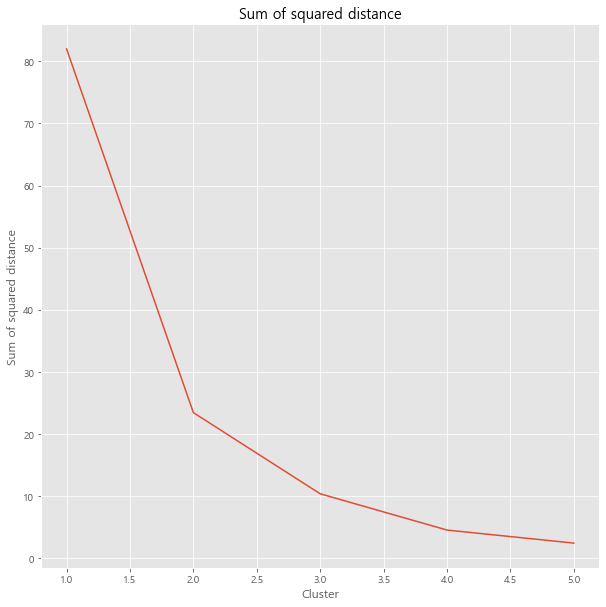

In [31]:
plt.figure(figsize = (10,10))
plt.plot(ds_error['NumberofCluster'], ds_error['Error'])
plt.title("Sum of squared distance")
plt.xlabel('Cluster')
plt.ylabel('Sum of squared distance')

#### 4-3) k-평균 군집 번호 생성

In [32]:
clus = KMeans(n_iter_cluster)
clus.fit(new_df_x)
cluster_kmeans = [i+1 for i in clus.labels_]
CLSS_df['ClusterKmeans'] = cluster_kmeans
CLSS_df.head()

,STD_CLSS_NM,AMT_diff,CNT_diff,ClusterKmeans
0,건강보조식품 소매업,4.175006,1.984703,5
1,골프장 운영업,43.958157,35.945830,5
2,과실 및 채소 소매업,17.382469,17.677383,5
3,관광 민예품 및 선물용품 소매업,13.921970,3.022211,5
4,그외 기타 분류안된 오락관련 서비스업,43.435699,32.258065,5


#### 4-4) k-평균 군집별 데이터 요약

In [33]:
ds_summary_km = CLSS_df.groupby("ClusterKmeans").agg(['min','mean','max'])
level0 = ds_summary_km.columns.get_level_values(0)
level1 = ds_summary_km.columns.get_level_values(1)
ds_summary_km.columns = level0 + '_' + level1
ds_summary_km.reset_index(inplace = True)
ds_summary_km.round(3)

,ClusterKmeans,AMT_diff_min,AMT_diff_mean,AMT_diff_max,CNT_diff_min,CNT_diff_mean,CNT_diff_max
0,1,-209.923,-192.307,-174.692,-361.996,-319.874,-277.751
1,2,-50.615,-23.047,-7.332,-48.457,-19.626,-3.665
2,3,-219.043,-166.152,-105.317,-138.636,-94.577,-63.389
3,4,-513.085,-513.085,-513.085,-485.359,-485.359,-485.359
4,5,-1.214,14.139,43.958,-12.435,12.307,35.946


In [34]:
CLSS_df[CLSS_df['ClusterKmeans']==1].sort_values(by='AMT_diff',ascending=False)

,STD_CLSS_NM,AMT_diff,CNT_diff,ClusterKmeans
5,그외 기타 스포츠시설 운영업,-174.691799,-361.996161,1
40,휴양콘도 운영업,-209.922574,-277.751328,1


In [35]:
CLSS_df[CLSS_df['ClusterKmeans']==2].sort_values(by='AMT_diff',ascending=False)

,STD_CLSS_NM,AMT_diff,CNT_diff,ClusterKmeans
16,비알콜 음료점업,-7.332196,-3.664560,2
31,중식 음식점업,-8.843247,-7.084746,2
15,버스 운송업,-10.325896,-6.834532,2
27,일식 음식점업,-13.530191,-13.032083,2
37,한식 음식점업,-14.864833,-11.774169,2
39,화장품 및 방향제 소매업,-16.361970,-18.692433,2
18,서양식 음식점업,-17.792984,-11.123519,2
9,기타 외국식 음식점업,-19.016294,-14.805953,2
10,기타 주점업,-19.334712,-21.715725,2
22,여관업,-20.758800,-14.422033,2


In [36]:
CLSS_df[CLSS_df['ClusterKmeans']==3].sort_values(by='AMT_diff',ascending=False)

,STD_CLSS_NM,AMT_diff,CNT_diff,ClusterKmeans
28,자동차 임대업,-105.317064,-138.636364,3
29,전시 및 행사 대행업,-174.096468,-63.389305,3
38,호텔업,-219.042821,-81.705531,3


In [37]:
CLSS_df[CLSS_df['ClusterKmeans']==4].sort_values(by='AMT_diff',ascending=False)

,STD_CLSS_NM,AMT_diff,CNT_diff,ClusterKmeans
14,면세점,-513.085419,-485.35859,4


In [38]:
CLSS_df[CLSS_df['ClusterKmeans']==5].sort_values(by='AMT_diff',ascending=False)

,STD_CLSS_NM,AMT_diff,CNT_diff,ClusterKmeans
1,골프장 운영업,43.958157,35.945830,5
4,그외 기타 분류안된 오락관련 서비스업,43.435699,32.258065,5
25,육류 소매업,20.304968,19.118689,5
11,기타음식료품위주종합소매업,20.185737,20.348289,5
19,수산물 소매업,19.894642,29.390240,5
2,과실 및 채소 소매업,17.382469,17.677383,5
6,그외 기타 종합 소매업,16.252152,17.121126,5
3,관광 민예품 및 선물용품 소매업,13.921970,3.022211,5
8,기타 수상오락 서비스업,13.271196,-12.435233,5
21,스포츠 및 레크레이션 용품 임대업,11.572817,14.472744,5


In [39]:
clss_dict = dict()
for i in range(n_iter_cluster):
    clss_dict[i] = list(CLSS_df[CLSS_df['ClusterKmeans']==i+1]['STD_CLSS_NM'].values)

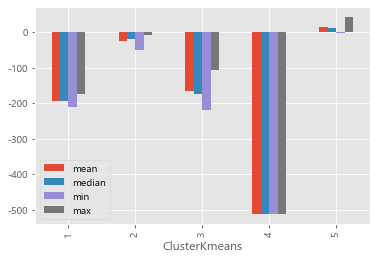

In [40]:
CLSS_df.groupby('ClusterKmeans')['AMT_diff'].agg(['mean','median', 'min', 'max']).plot(kind='bar')

In [41]:
cl1 = df[df['STD_CLSS_NM'].map(lambda x: x in clss_dict[0])]
cl2 = df[df['STD_CLSS_NM'].map(lambda x: x in clss_dict[1])]
cl3 = df[df['STD_CLSS_NM'].map(lambda x: x in clss_dict[2])]
cl4 = df[df['STD_CLSS_NM'].map(lambda x: x in clss_dict[3])]
cl5 = df[df['STD_CLSS_NM'].map(lambda x: x in clss_dict[4])]

In [42]:
cl1.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,CV
82,201901,강원,그외 기타 스포츠시설 운영업,20s,1,1,19,253600,25,0
83,201901,강원,그외 기타 스포츠시설 운영업,30s,1,2,9,420500,11,0
84,201901,강원,그외 기타 스포츠시설 운영업,30s,2,2,4,96000,5,0
85,201901,강원,그외 기타 스포츠시설 운영업,40s,1,2,3,60200,3,0
86,201901,강원,그외 기타 스포츠시설 운영업,40s,1,3,24,4038800,34,0


In [43]:
cl1.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,CV
82,201901,강원,그외 기타 스포츠시설 운영업,20s,1,1,19,253600,25,0
83,201901,강원,그외 기타 스포츠시설 운영업,30s,1,2,9,420500,11,0
84,201901,강원,그외 기타 스포츠시설 운영업,30s,2,2,4,96000,5,0
85,201901,강원,그외 기타 스포츠시설 운영업,40s,1,2,3,60200,3,0
86,201901,강원,그외 기타 스포츠시설 운영업,40s,1,3,24,4038800,34,0


In [44]:
cl1.to_csv('../Other/cl1.csv', index=False, encoding='utf-8-sig')
cl2.to_csv('../Other/cl2.csv', index=False, encoding='utf-8-sig')
cl3.to_csv('../Other/cl3.csv', index=False, encoding='utf-8-sig')
cl4.to_csv('../Other/cl4.csv', index=False, encoding='utf-8-sig')
cl5.to_csv('../Other/cl5.csv', index=False, encoding='utf-8-sig')